<a href="https://colab.research.google.com/github/Pathway2008/Weblog/blob/main/RFE_lambda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
train = pd.read_csv('/content/drive/MyDrive/Weblog/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Weblog/test.csv')
sub = pd.read_csv('/content/drive/MyDrive/Weblog/sample_submission.csv')

In [2]:
train.drop(['sessionID','userID'],axis=1,inplace=True)
test.drop(['sessionID','userID'],axis=1,inplace=True)

In [3]:
import warnings
import matplotlib.font_manager as fm
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
warnings.filterwarnings('ignore')
!apt-get -qq install fonts-nanum


fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
    name='NanumGothic')
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size': 18, 'font.family': 'NanumGothic'})

Selecting previously unselected package fonts-nanum.
(Reading database ... 121749 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


In [4]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
object_columns = train.drop(columns=['TARGET']).select_dtypes(include='object')
for feature in object_columns.columns:
    le = LabelEncoder()

    # Convert the column to string type
    train[feature] = train[feature].astype(str)
    le.fit(train[feature])
    train[feature] = le.transform(train[feature])

    # Make sure the test set has the same data type
    test[feature] = test[feature].astype(str)

    # Handle unseen labels in the test set
    for label in np.unique(test[feature]):
        if label not in le.classes_:
            le.classes_ = np.append(le.classes_, label)

    test[feature] = le.transform(test[feature])

In [5]:
train['trans'] = train.apply(lambda row: 0 if row['transaction'] == 0 else row['transaction_revenue'] / row['transaction'], axis=1)
train['duration/quality'] = train['duration'] / train['quality']
train['duration*quality'] = train['duration'] * train['quality']

In [6]:
test['trans'] = test.apply(lambda row: 0 if row['transaction'] == 0 else row['transaction_revenue'] / row['transaction'], axis=1)
test['duration/quality'] = test['duration'] / test['quality']
test['duration*quality'] = test['duration'] * test['quality']

In [35]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252289 entries, 0 to 252288
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   TARGET               252289 non-null  float64
 1   browser              252289 non-null  int64  
 2   OS                   252289 non-null  int64  
 3   device               252289 non-null  int64  
 4   new                  252289 non-null  int64  
 5   quality              252289 non-null  float64
 6   duration             252289 non-null  float64
 7   bounced              252289 non-null  int64  
 8   transaction          252289 non-null  float64
 9   transaction_revenue  252289 non-null  float64
 10  continent            252289 non-null  int64  
 11  subcontinent         252289 non-null  int64  
 12  country              252289 non-null  int64  
 13  traffic_source       252289 non-null  int64  
 14  traffic_medium       252289 non-null  int64  
 15  keyword          

In [ ]:
train.head()

,TARGET,browser,OS,device,new,quality,duration,bounced,transaction,transaction_revenue,continent,subcontinent,country,traffic_source,traffic_medium,keyword,referral_path
0,17.0,27,7,0,0,45.0,839.0,0,0.0,0.0,2,12,196,46,5,621,1578
1,3.0,27,17,0,1,1.0,39.0,0,0.0,0.0,4,22,67,46,5,621,1578
2,1.0,51,1,1,1,1.0,0.0,1,0.0,0.0,3,16,115,0,0,623,1578
3,1.0,27,7,0,1,1.0,0.0,1,0.0,0.0,2,12,196,1,2,623,1578
4,1.0,27,20,1,0,1.0,0.0,1,0.0,0.0,2,12,196,87,6,623,1180


In [7]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 9.2 MB/s eta 0:00:00


In [8]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import xgboost as xgb
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split
from math import sqrt
from sklearn.metrics import make_scorer, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [9]:
from sklearn.model_selection import KFold
kf = StratifiedKFold(n_splits=5, shuffle=False)

In [14]:
from sklearn.model_selection import KFold
kf2 = StratifiedKFold(n_splits=10, shuffle=False)

In [10]:
def rmse_scorer(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [46]:
from sklearn.model_selection import train_test_split
X = train.drop(['TARGET'], axis=1)#(dev,trm,key
y = train['TARGET']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 43)

In [47]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 176602 entries, 79382 to 14148
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   browser              176602 non-null  int64  
 1   OS                   176602 non-null  int64  
 2   device               176602 non-null  int64  
 3   new                  176602 non-null  int64  
 4   quality              176602 non-null  float64
 5   duration             176602 non-null  float64
 6   bounced              176602 non-null  int64  
 7   transaction          176602 non-null  float64
 8   transaction_revenue  176602 non-null  float64
 9   continent            176602 non-null  int64  
 10  subcontinent         176602 non-null  int64  
 11  country              176602 non-null  int64  
 12  traffic_source       176602 non-null  int64  
 13  traffic_medium       176602 non-null  int64  
 14  keyword              176602 non-null  int64  
 15  referral_path 

In [43]:
X_train.drop(['duration*quality'],axis=1,inplace=True)
X_test.drop(['duration/quality'],axis=1,inplace=True)

In [44]:
# Random Forest
rf_model = RandomForestRegressor(random_state=43)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_scores = cross_val_score(rf_model, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
rf_rmse = rmse_scorer(y_test, rf_predictions)


# Extra Trees
et_model = ExtraTreesRegressor(random_state=43)
et_model.fit(X_train, y_train)
et_predictions = et_model.predict(X_test)
et_scores = cross_val_score(et_model, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
et_rmse = rmse_scorer(y_test, et_predictions)

# #xgb
# xgb_model2 = xgb.XGBRegressor(random_state=43)
# xgb_model2.fit(X_train, y_train)
# xgb_predictions2 = xgb_model2.predict(X_test)
# xgb_scores2 = cross_val_score(xgb_model2, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
# xgb_rmse2 = rmse_scorer(y_test, xgb_predictions2)

#xgb
xgb_model = xgb.XGBRegressor(random_state=43, reg_lambda=4)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
xgb_scores = cross_val_score(xgb_model, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
xgb_rmse = rmse_scorer(y_test, xgb_predictions)

# #cat
# cat_model2 = CatBoostRegressor(random_seed=43)
# cat_model2.fit(X_train, y_train)
# cat_predictions2 = cat_model2.predict(X_test)
# cat_scores2 = cross_val_score(cat_model2, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
# cat_rmse2 = rmse_scorer(y_test, cat_predictions2)

#cat
cat_model = CatBoostRegressor(random_seed=43, l2_leaf_reg=4, verbose=0)
cat_model.fit(X_train, y_train)
cat_predictions = cat_model.predict(X_test)
cat_scores = cross_val_score(cat_model, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
cat_rmse = rmse_scorer(y_test, cat_predictions)

#lgb
lgb_model2 = LGBMRegressor(random_state=43)
lgb_model2.fit(X_train, y_train)
lgb_predictions2 = lgb_model2.predict(X_test)
lgb_scores2 = cross_val_score(lgb_model2, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
lgb_rmse2 = rmse_scorer(y_test, lgb_predictions2)

# #lgb
# lgb_model = LGBMRegressor(random_state=43, reg_lambda=4)
# lgb_model.fit(X_train, y_train)
# lgb_predictions = lgb_model.predict(X_test)
# lgb_scores = cross_val_score(lgb_model, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
# lgb_rmse = rmse_scorer(y_test, lgb_predictions)


# logreg_model = LogisticRegression(random_state=43)
# logreg_model.fit(X_train, y_train)
# logreg_predictions = logreg_model.predict(X_test)
# logreg_scores = cross_val_score(logreg_model, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
# logreg_rmse = rmse_scorer(y_test, logreg_predictions)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.020205 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1346
[LightGBM] [Info] Number of data points in the train set: 176602, number of used features: 16
[LightGBM] [Info] Start training from score 3.592853
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1331
[LightGBM] [Info] Number of data points in the train set: 141281, number of used features: 16
[LightGBM] [Info] Start training from score 3.593965
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015831 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

In [ ]:
#xgb, cat은 lambda적용

In [13]:
print(f'Random Forest Cross-Validation RMSE: {rf_scores.mean()}')
print(f'RF test RMSE: {rf_rmse}\n')
print(f'Extra Trees Cross-Validation RMSE: {et_scores.mean()}')
print(f'ET test RMSE: {et_rmse}\n')
print(f'XGBoost Cross-Validation RMSE: {xgb_scores2.mean()}')
print(f'XGBoost test RMSE: {xgb_rmse2}\n')
print(f'XGBoost Cross-Validation RMSE: {xgb_scores.mean()}')
print(f'XGBoost test RMSE: {xgb_rmse}\n')
print(f'CatBoost Cross-Validation RMSE: {cat_scores2.mean()}')
print(f'CatBoost test RMSE: {cat_rmse2}\n')
print(f'CatBoost Cross-Validation RMSE: {cat_scores.mean()}')
print(f'CatBoost test RMSE: {cat_rmse}\n')
# print(f'Logistic Cross-Validation RMSE: {logreg_scores.mean()}')
# print(f'logistic test RMSE: {logreg_rmse}\n')
print(f"Cross-validated LightGBM scores: {lgb_scores2.mean()}")
print(f"LightGBM RMSE on test set: {lgb_rmse2}\n")
print(f"Cross-validated LightGBM scores: {lgb_scores.mean()}")
print(f"LightGBM RMSE on test set: {lgb_rmse}")

Random Forest Cross-Validation RMSE: 2.851839912551597
RF test RMSE: 2.9326420510552555

Extra Trees Cross-Validation RMSE: 2.8823727958727403
ET test RMSE: 2.928257013400541

XGBoost Cross-Validation RMSE: 2.8370085530500093
XGBoost test RMSE: 2.874057308430686

XGBoost Cross-Validation RMSE: 2.7774646486526167
XGBoost test RMSE: 2.8362344027389375

CatBoost Cross-Validation RMSE: 2.7388401404295335
CatBoost test RMSE: 2.744493195345724

CatBoost Cross-Validation RMSE: 2.7504343169355705
CatBoost test RMSE: 2.7611192918561107

Cross-validated LightGBM scores: 2.7325711104254102
LightGBM RMSE on test set: 2.725954592506087

Cross-validated LightGBM scores: 2.737463870306459
LightGBM RMSE on test set: 2.7340070041664295


In [39]:
#drop trans
print(f'Random Forest Cross-Validation RMSE: {rf_scores.mean()}')
print(f'RF test RMSE: {rf_rmse}\n')
print(f'Extra Trees Cross-Validation RMSE: {et_scores.mean()}')
print(f'ET test RMSE: {et_rmse}\n')

print(f'XGBoost Cross-Validation RMSE: {xgb_scores.mean()}')
print(f'XGBoost test RMSE: {xgb_rmse}\n')

print(f'CatBoost Cross-Validation RMSE: {cat_scores.mean()}')
print(f'CatBoost test RMSE: {cat_rmse}\n')

print(f"Cross-validated LightGBM scores: {lgb_scores2.mean()}")
print(f"LightGBM RMSE on test set: {lgb_rmse2}\n")

Random Forest Cross-Validation RMSE: 2.9786918023152857
RF test RMSE: 2.796135077258001

Extra Trees Cross-Validation RMSE: 3.0407598769448265
ET test RMSE: 3.006956602843383

XGBoost Cross-Validation RMSE: 2.912996077050515
XGBoost test RMSE: 2.914915534955627

CatBoost Cross-Validation RMSE: 2.849650183085191
CatBoost test RMSE: 2.6681204367616655

Cross-validated LightGBM scores: 2.80994273182104
LightGBM RMSE on test set: 2.5936077290927346



In [45]:
#drop 3col = basic
print(f'Random Forest Cross-Validation RMSE: {rf_scores.mean()}')
print(f'RF test RMSE: {rf_rmse}\n')
print(f'Extra Trees Cross-Validation RMSE: {et_scores.mean()}')
print(f'ET test RMSE: {et_rmse}\n')

print(f'XGBoost Cross-Validation RMSE: {xgb_scores.mean()}')
print(f'XGBoost test RMSE: {xgb_rmse}\n')

print(f'CatBoost Cross-Validation RMSE: {cat_scores.mean()}')
print(f'CatBoost test RMSE: {cat_rmse}\n')

print(f"Cross-validated LightGBM scores: {lgb_scores2.mean()}")
print(f"LightGBM RMSE on test set: {lgb_rmse2}\n")

Random Forest Cross-Validation RMSE: 2.9804623791953153
RF test RMSE: 2.8135714539355696

Extra Trees Cross-Validation RMSE: 3.063157639246558
ET test RMSE: 3.0293153015209437

XGBoost Cross-Validation RMSE: 3.0198883003663743
XGBoost test RMSE: 2.628839210971769

CatBoost Cross-Validation RMSE: 2.879113975437857
CatBoost test RMSE: 2.557277720175142

Cross-validated LightGBM scores: 2.841424694801416
LightGBM RMSE on test set: 2.565043585558141



###cv=10

In [55]:
# Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_scores = cross_val_score(rf_model, X_train, y_train, cv=kf2, scoring=make_scorer(rmse_scorer))
rf_rmse = rmse_scorer(y_test, rf_predictions)


# Extra Trees
et_model = ExtraTreesRegressor(random_state=42)
et_model.fit(X_train, y_train)
et_predictions = et_model.predict(X_test)
et_scores = cross_val_score(et_model, X_train, y_train, cv=kf2, scoring=make_scorer(rmse_scorer))
et_rmse = rmse_scorer(y_test, et_predictions)

# #xgb
# xgb_model2 = xgb.XGBRegressor(random_state=42)
# xgb_model2.fit(X_train, y_train)
# xgb_predictions2 = xgb_model2.predict(X_test)
# xgb_scores2 = cross_val_score(xgb_model2, X_train, y_train, cv=kf2, scoring=make_scorer(rmse_scorer))
# xgb_rmse2 = rmse_scorer(y_test, xgb_predictions2)

#xgb
xgb_model = xgb.XGBRegressor(random_state=42, reg_lambda=4)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
xgb_scores = cross_val_score(xgb_model, X_train, y_train, cv=kf2, scoring=make_scorer(rmse_scorer))
xgb_rmse = rmse_scorer(y_test, xgb_predictions)

# #cat
# cat_model2 = CatBoostRegressor(random_seed=42)
# cat_model2.fit(X_train, y_train)
# cat_predictions2 = cat_model2.predict(X_test)
# cat_scores2 = cross_val_score(cat_model2, X_train, y_train, cv=kf2, scoring=make_scorer(rmse_scorer))
# cat_rmse2 = rmse_scorer(y_test, cat_predictions2)

#cat
cat_model = CatBoostRegressor(random_seed=42, l2_leaf_reg=4, verbose=0)
cat_model.fit(X_train, y_train)
cat_predictions = cat_model.predict(X_test)
cat_scores = cross_val_score(cat_model, X_train, y_train, cv=kf2, scoring=make_scorer(rmse_scorer))
cat_rmse = rmse_scorer(y_test, cat_predictions)

#lgb
lgb_model2 = LGBMRegressor(random_state=42)
lgb_model2.fit(X_train, y_train)
lgb_predictions2 = lgb_model2.predict(X_test)
lgb_scores2 = cross_val_score(lgb_model2, X_train, y_train, cv=kf2, scoring=make_scorer(rmse_scorer))
lgb_rmse2 = rmse_scorer(y_test, lgb_predictions2)

# #lgb
# lgb_model = LGBMRegressor(random_state=42, reg_lambda=4)
# lgb_model.fit(X_train, y_train)
# lgb_predictions = lgb_model.predict(X_test)
# lgb_scores = cross_val_score(lgb_model, X_train, y_train, cv=kf2, scoring=make_scorer(rmse_scorer))
# lgb_rmse = rmse_scorer(y_test, lgb_predictions)


# logreg_model = LogisticRegression(random_state=43)
# logreg_model.fit(X_train, y_train)
# logreg_predictions = logreg_model.predict(X_test)
# logreg_scores = cross_val_score(logreg_model, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
# logreg_rmse = rmse_scorer(y_test, logreg_predictions)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.022467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2115
[LightGBM] [Info] Number of data points in the train set: 176602, number of used features: 19
[LightGBM] [Info] Start training from score 3.593011
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019700 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2108
[LightGBM] [Info] Number of data points in the train set: 158941, number of used features: 19
[LightGBM] [Info] Start training from score 3.593164
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.030301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

In [19]:
print(f'CatBoost Cross-Validation RMSE: {cat_scores2.mean()}')
print(f'CatBoost test RMSE: {cat_rmse2}\n')
print(f'CatBoost Cross-Validation RMSE: {cat_scores.mean()}')
print(f'CatBoost test RMSE: {cat_rmse}\n')

CatBoost Cross-Validation RMSE: 2.798586994502862
CatBoost test RMSE: 2.7376666446063576

CatBoost Cross-Validation RMSE: 2.7872754583813917
CatBoost test RMSE: 2.650197881508862



In [21]:
print(f'Random Forest Cross-Validation RMSE: {rf_scores.mean()}')
print(f'RF test RMSE: {rf_rmse}\n')
print(f'Extra Trees Cross-Validation RMSE: {et_scores.mean()}')
print(f'ET test RMSE: {et_rmse}\n')
print(f'XGBoost Cross-Validation RMSE: {xgb_scores.mean()}')
print(f'XGBoost test RMSE: {xgb_rmse}\n')
print(f"Cross-validated LightGBM scores: {lgb_scores2.mean()}")
print(f"LightGBM RMSE on test set: {lgb_rmse2}\n")

Random Forest Cross-Validation RMSE: 2.918290988717626
RF test RMSE: 2.7859573038747842

Extra Trees Cross-Validation RMSE: 3.0232406426554124
ET test RMSE: 2.966785189114846

XGBoost Cross-Validation RMSE: 2.8928217875368825
XGBoost test RMSE: 2.8261710193333496

Cross-validated LightGBM scores: 2.7761384297016125
LightGBM RMSE on test set: 2.5983906582619176



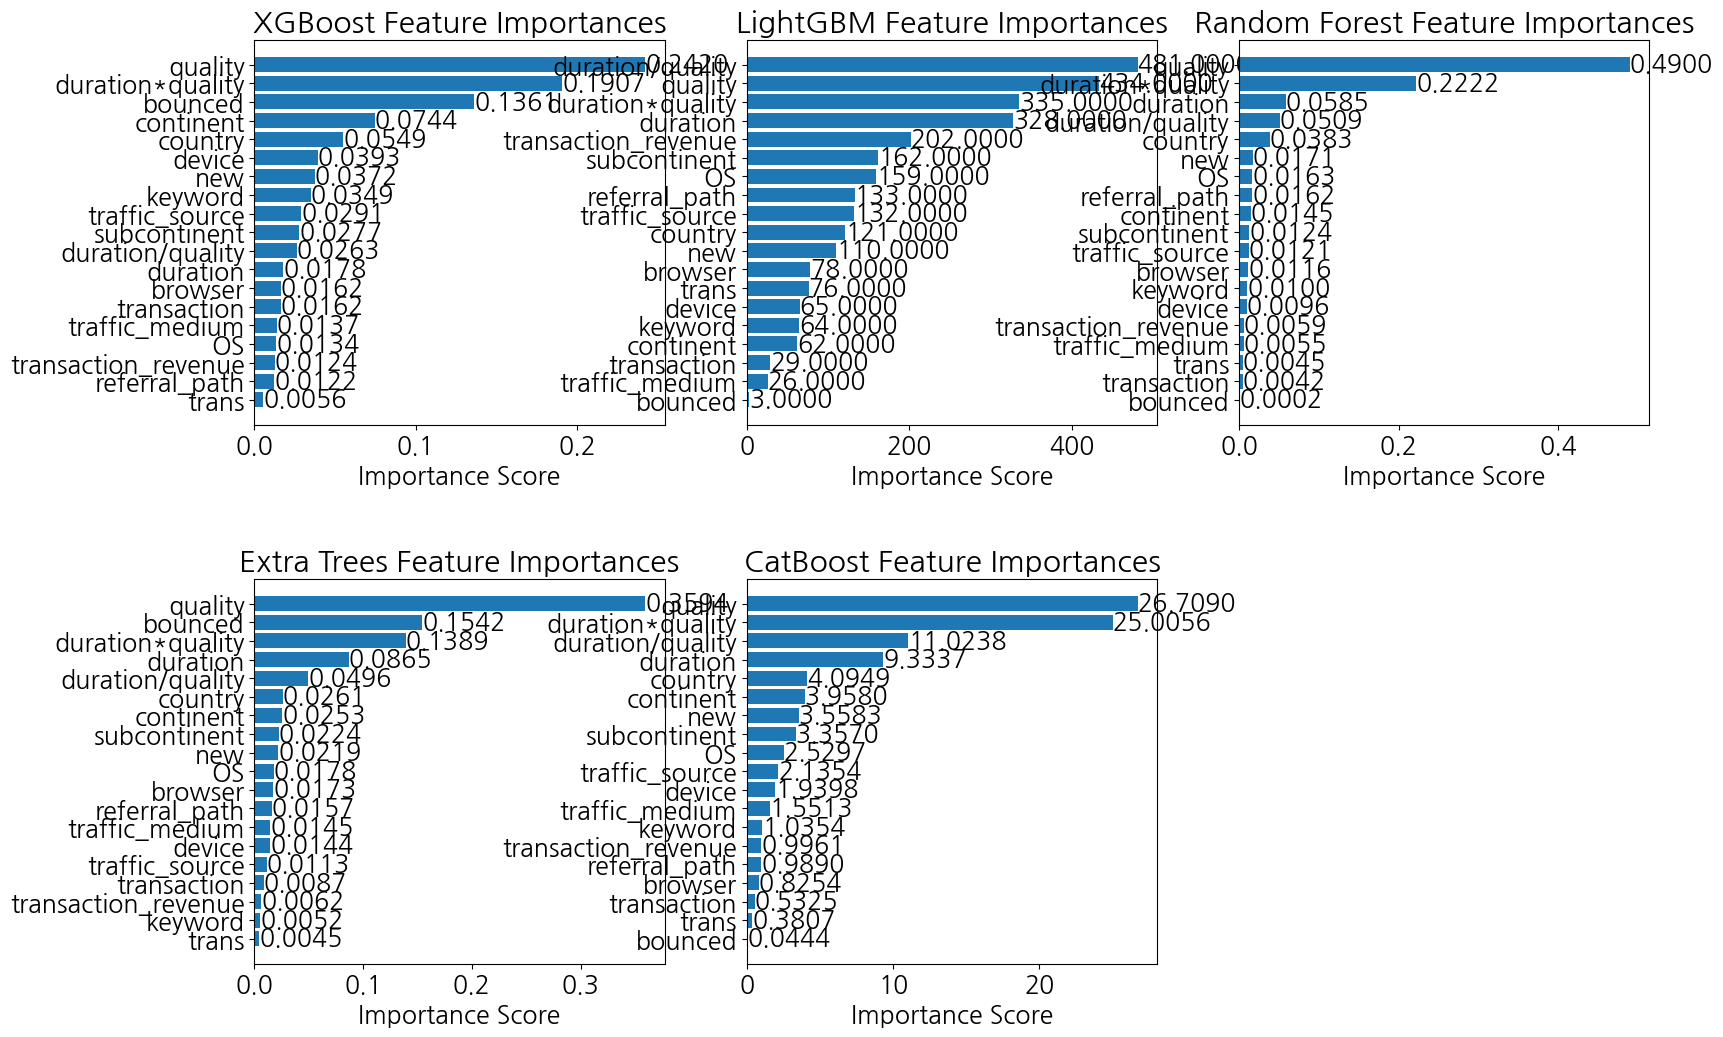

In [56]:
import matplotlib.pyplot as plt

feature_importances_xgb = xgb_model.feature_importances_
importance_df_xgb = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances_xgb})
importance_df_xgb = importance_df_xgb.sort_values(by='Importance')


feature_importances_lgb = lgb_model2.feature_importances_
importance_df_lgb = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances_lgb})
importance_df_lgb = importance_df_lgb.sort_values(by='Importance')


feature_importances_rf = rf_model.feature_importances_
importance_df_rf = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances_rf})
importance_df_rf = importance_df_rf.sort_values(by='Importance')


feature_importances_et = et_model.feature_importances_
importance_df_et = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances_et})
importance_df_et = importance_df_et.sort_values(by='Importance')

feature_importances_cat = cat_model.feature_importances_
importance_df_cat = pd.DataFrame({'Feature': X_train.columns, 'Importance': feature_importances_cat})
importance_df_cat = importance_df_cat.sort_values(by='Importance')

# Plot feature importances for each model
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.subplots_adjust(hspace=0.4)

# XGBoost
axes[0, 0].barh(importance_df_xgb['Feature'], importance_df_xgb['Importance'])
axes[0, 0].set_xlabel('Importance Score')
axes[0, 0].set_title('XGBoost Feature Importances')
for index, value in enumerate(importance_df_xgb['Importance']):
    axes[0, 0].text(value, index, f'{value:.4f}', ha='left', va='center')

# LightGBM
axes[0, 1].barh(importance_df_lgb['Feature'], importance_df_lgb['Importance'])
axes[0, 1].set_xlabel('Importance Score')
axes[0, 1].set_title('LightGBM Feature Importances')
for index, value in enumerate(importance_df_lgb['Importance']):
    axes[0, 1].text(value, index, f'{value:.4f}', ha='left', va='center')

# Random Forest
axes[0, 2].barh(importance_df_rf['Feature'], importance_df_rf['Importance'])
axes[0, 2].set_xlabel('Importance Score')
axes[0, 2].set_title('Random Forest Feature Importances')
for index, value in enumerate(importance_df_rf['Importance']):
    axes[0, 2].text(value, index, f'{value:.4f}', ha='left', va='center')

# Extra Trees
axes[1, 0].barh(importance_df_et['Feature'], importance_df_et['Importance'])
axes[1, 0].set_xlabel('Importance Score')
axes[1, 0].set_title('Extra Trees Feature Importances')
for index, value in enumerate(importance_df_et['Importance']):
    axes[1, 0].text(value, index, f'{value:.4f}', ha='left', va='center')

# CatBoost
axes[1, 1].barh(importance_df_cat['Feature'], importance_df_cat['Importance'])
axes[1, 1].set_xlabel('Importance Score')
axes[1, 1].set_title('CatBoost Feature Importances')
for index, value in enumerate(importance_df_cat['Importance']):
    axes[1, 1].text(value, index, f'{value:.4f}', ha='left', va='center')
# Remove the empty subplot
fig.delaxes(axes[1, 2])

plt.show()

In [ ]:
from sklearn.ensemble import VotingRegressor
voting_regressor = VotingRegressor([('xgb', xgb_model), ('catboost', cat_model),('lgb',lgb_model2),('et',et_model),('rf',rf_model)])
voting_regressor.fit(X_train, y_train)#.drop(['device','transaction_revenue','traffic_source'],axis=1)

voting_predictions = voting_regressor.predict(X_test)

voting_rmse = rmse_scorer(y_test, voting_predictions)
voting_scores = cross_val_score(voting_regressor, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))

In [23]:
print(f'VotingRegressor Cross-Validation RMSE: {voting_scores.mean()}')
print(f'VotingRegressor test RMSE: {voting_rmse}')

VotingRegressor Cross-Validation RMSE: 2.812257980778629
VotingRegressor test RMSE: 2.6379649412891735


In [24]:
voting_predictions = voting_regressor.predict(test)
neg = [x for x in voting_predictions if x < 0]
neg

[]

In [27]:
sub['TARGET'] = voting_predictions
sub.to_csv('col3_xgbcat_lambda.csv',index=False)

#RFECV

In [ ]:
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.feature_selection import RFECV
import matplotlib.pyplot as plt
import numpy as np

def perform_rfecv(estimator, X_train, y_train, X_test, y_test, model_name):
    # Create RFECV object
    rfecv = RFECV(estimator=estimator, step=1, cv=kf, scoring='neg_mean_squared_error')

    # Fit RFECV on the training data
    rfecv.fit(X_train, y_train)

    # Get the selected features
    selected_features = X_train.columns[rfecv.support_]

    # Print the selected features
    print(f"Selected Features for {model_name}:", rfecv.support_.sum())
    print(f"Selected Features for {model_name}:", selected_features)

    # Transform the training and testing sets using only the selected features
    X_train_selected = rfecv.transform(X_train)
    X_test_selected = rfecv.transform(X_test)

    # Now, you can train your model using the selected features
    estimator.fit(X_train_selected, y_train)
    predictions = estimator.predict(X_test_selected)

    # Evaluate the model using RMSE
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    print(f"{model_name} RMSE:", rmse)

    # Plot the number of selected features vs. cross-validated RMSE score
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1), np.sqrt(-rfecv.cv_results_['mean_test_score']), marker='o', linestyle='-', color='b')
    plt.title(f'{model_name} RMSE vs. Number of Features')
    plt.xlabel('Number of Features Selected')
    plt.ylabel(f'{model_name} RMSE Score')
    plt.grid(True)
    plt.show()

Selected Features for xgb_lambda: 19
Selected Features for xgb_lambda: Index(['browser', 'OS', 'device', 'new', 'quality', 'duration', 'bounced',
       'transaction', 'transaction_revenue', 'continent', 'subcontinent',
       'country', 'traffic_source', 'traffic_medium', 'keyword',
       'referral_path', 'trans', 'duration/quality', 'duration*quality'],
      dtype='object')
xgb_lambda RMSE: 2.8362344027389375


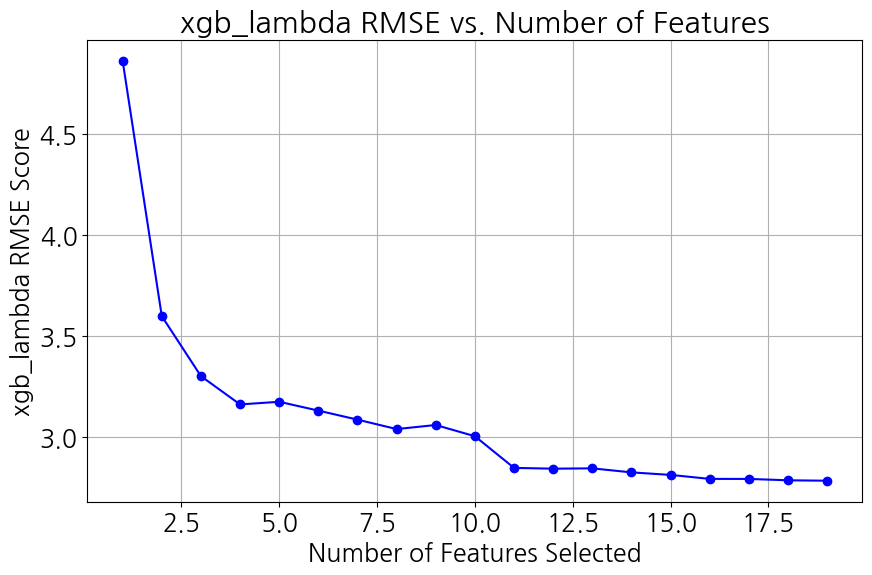

Selected Features for xgb_no: 15
Selected Features for xgb_no: Index(['OS', 'device', 'new', 'quality', 'duration', 'bounced', 'transaction',
       'continent', 'subcontinent', 'country', 'traffic_source',
       'traffic_medium', 'keyword', 'duration/quality', 'duration*quality'],
      dtype='object')
xgb_no RMSE: 2.9326466359696104


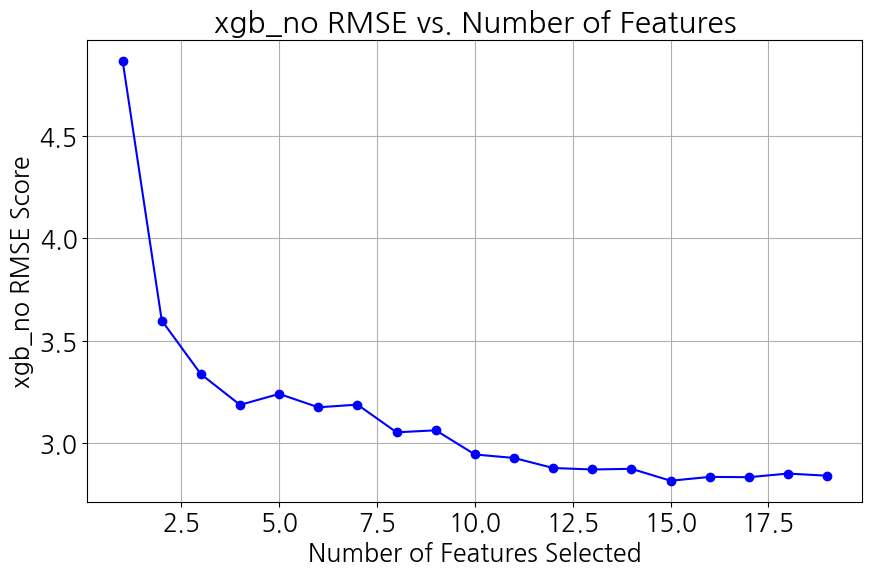

Selected Features for rf: 18
Selected Features for rf: Index(['browser', 'OS', 'device', 'new', 'quality', 'duration', 'transaction',
       'transaction_revenue', 'continent', 'subcontinent', 'country',
       'traffic_source', 'traffic_medium', 'keyword', 'referral_path', 'trans',
       'duration/quality', 'duration*quality'],
      dtype='object')
rf RMSE: 2.956989782905834


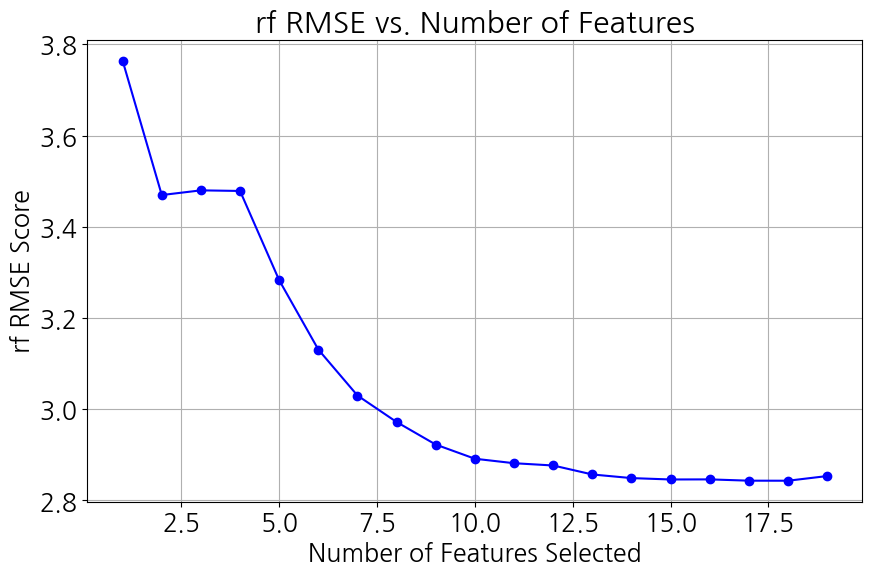

Selected Features for et: 19
Selected Features for et: Index(['browser', 'OS', 'device', 'new', 'quality', 'duration', 'bounced',
       'transaction', 'transaction_revenue', 'continent', 'subcontinent',
       'country', 'traffic_source', 'traffic_medium', 'keyword',
       'referral_path', 'trans', 'duration/quality', 'duration*quality'],
      dtype='object')
et RMSE: 2.928257013400541


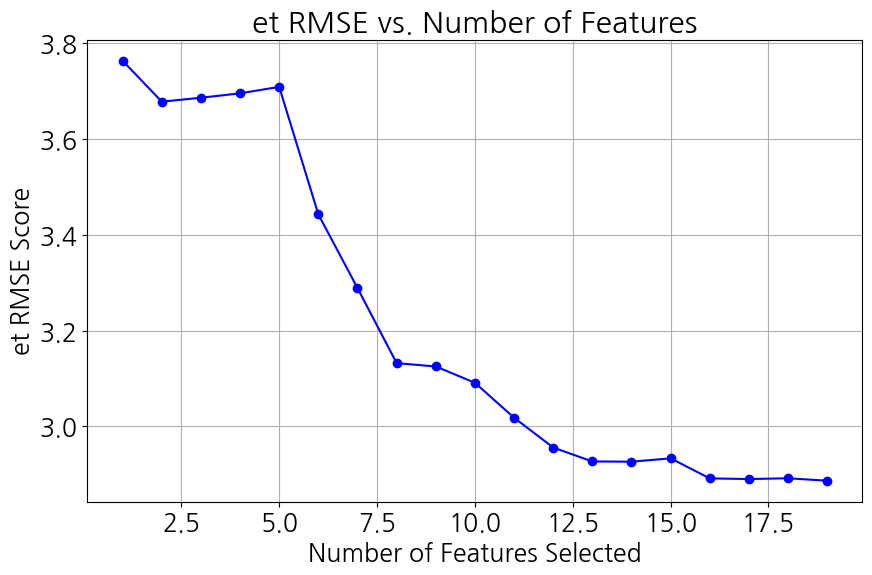

In [ ]:
perform_rfecv(xgb_model, X_train, y_train, X_test, y_test, 'xgb_lambda')
perform_rfecv(xgb_model2, X_train, y_train, X_test, y_test, 'xgb_no')
perform_rfecv(rf_model, X_train, y_train, X_test, y_test, 'rf')
perform_rfecv(et_model, X_train, y_train, X_test, y_test, 'et')

Selected Features for cat_lambda: 14
Selected Features for cat_lambda: Index(['OS', 'device', 'new', 'quality', 'duration', 'transaction_revenue',
       'continent', 'subcontinent', 'country', 'traffic_source',
       'traffic_medium', 'keyword', 'duration/quality', 'duration*quality'],
      dtype='object')
cat_lambda RMSE: 2.8106454035518396


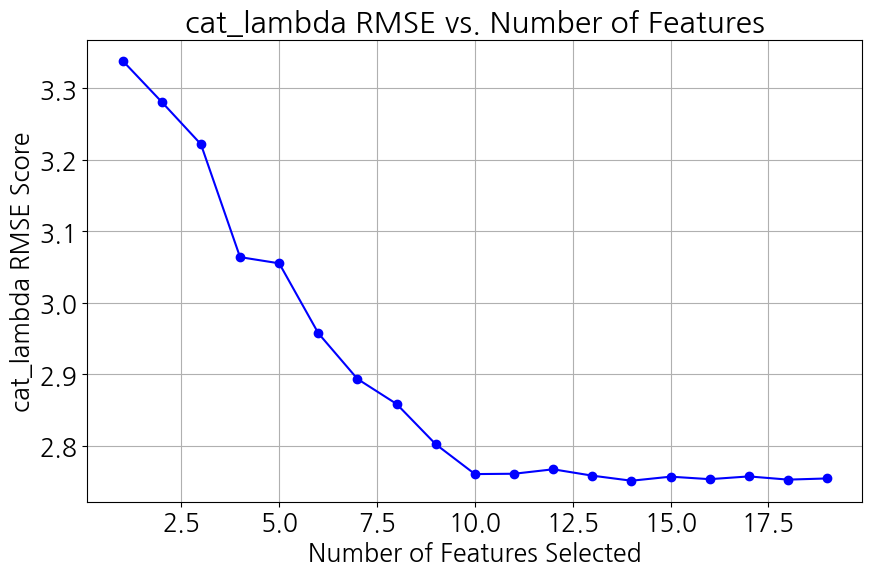

In [ ]:
perform_rfecv(cat_model, X_train, y_train, X_test, y_test, 'cat_lambda')

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
11:	learn: 3.5555524	total: 193ms	remaining: 15.9s
12:	learn: 3.4998714	total: 210ms	remaining: 15.9s
13:	learn: 3.4506906	total: 224ms	remaining: 15.8s
14:	learn: 3.4101752	total: 240ms	remaining: 15.8s
15:	learn: 3.3735734	total: 255ms	remaining: 15.7s
16:	learn: 3.3427211	total: 269ms	remaining: 15.6s
17:	learn: 3.3136114	total: 284ms	remaining: 15.5s
18:	learn: 3.2898688	total: 299ms	remaining: 15.4s
19:	learn: 3.2683233	total: 313ms	remaining: 15.3s
20:	learn: 3.2500745	total: 328ms	remaining: 15.3s
21:	learn: 3.2352571	total: 343ms	remaining: 15.3s
22:	learn: 3.2216244	total: 358ms	remaining: 15.2s
23:	learn: 3.2102335	total: 373ms	remaining: 15.2s
24:	learn: 3.2003008	total: 388ms	remaining: 15.1s
25:	learn: 3.1885058	total: 415ms	remaining: 15.6s
26:	learn: 3.1810698	total: 431ms	remaining: 15.5s
27:	learn: 3.1744607	total: 446ms	remaining: 15.5s
28:	learn: 3.1683538	total: 461ms	remaining: 15.4s
29:	learn: 3.1592213	total: 476ms	remaining: 1

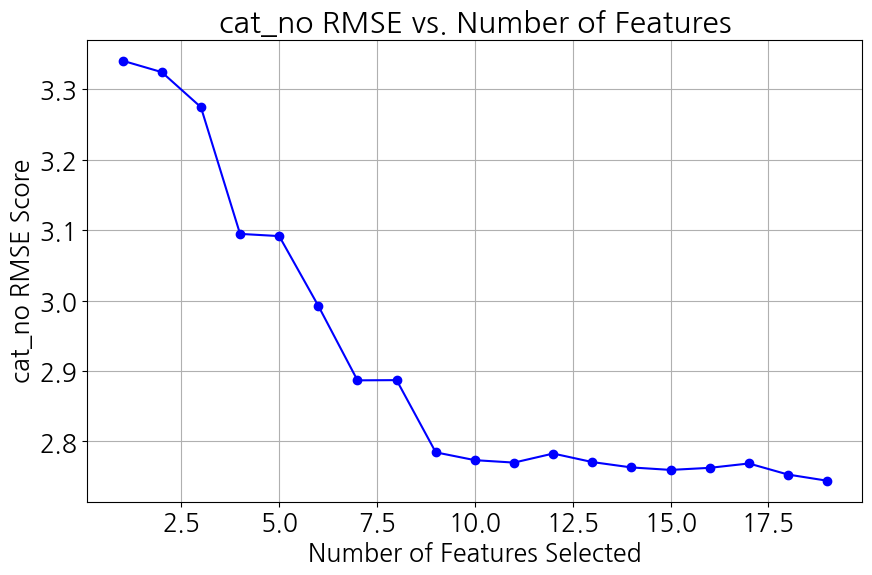

In [ ]:
perform_rfecv(cat_model2, X_train, y_train, X_test, y_test, 'cat_no')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.039919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 141281, number of used features: 19
[LightGBM] [Info] Start training from score 3.593406
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018584 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2096
[LightGBM] [Info] Number of data points in the train set: 141281, number of used features: 18
[LightGBM] [Info] Start training from score 3.593406
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017113 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total 

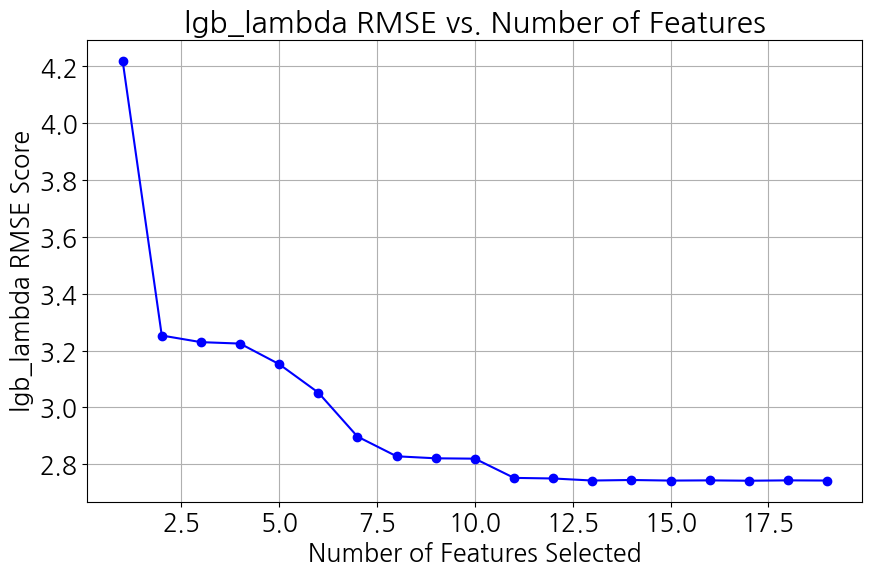

In [ ]:
perform_rfecv(lgb_model, X_train, y_train, X_test, y_test, 'lgb_lambda')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 141281, number of used features: 19
[LightGBM] [Info] Start training from score 3.593406
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2096
[LightGBM] [Info] Number of data points in the train set: 141281, number of used features: 18
[LightGBM] [Info] Start training from score 3.593406
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018274 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total 

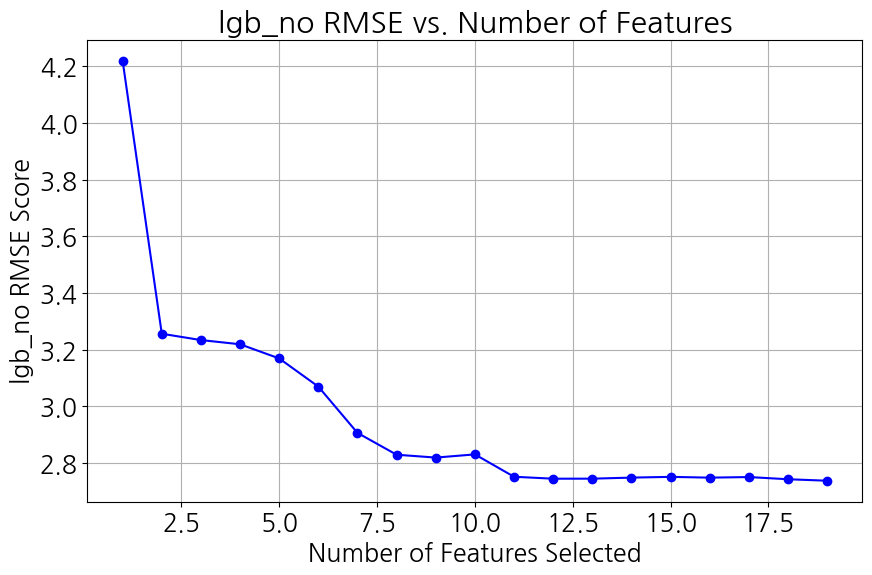

In [ ]:
perform_rfecv(lgb_model2, X_train, y_train, X_test, y_test, 'lgb_no')

#fitting

In [48]:
# Random Forest
rf_model = RandomForestRegressor(random_state=43)
rf_model.fit(X_train[['browser', 'OS', 'device', 'new', 'quality', 'duration', 'transaction',
       'transaction_revenue', 'continent', 'subcontinent', 'country',
       'traffic_source', 'traffic_medium', 'keyword', 'referral_path', 'trans',
       'duration/quality', 'duration*quality']], y_train)
rf_predictions = rf_model.predict(X_test[['browser', 'OS', 'device', 'new', 'quality', 'duration', 'transaction',
       'transaction_revenue', 'continent', 'subcontinent', 'country',
       'traffic_source', 'traffic_medium', 'keyword', 'referral_path', 'trans',
       'duration/quality', 'duration*quality']])
rf_scores = cross_val_score(rf_model, X_train[['browser', 'OS', 'device', 'new', 'quality', 'duration', 'transaction',
       'transaction_revenue', 'continent', 'subcontinent', 'country',
       'traffic_source', 'traffic_medium', 'keyword', 'referral_path', 'trans',
       'duration/quality', 'duration*quality']], y_train, cv=kf, scoring=make_scorer(rmse_scorer))
rf_rmse = rmse_scorer(y_test, rf_predictions)


# Extra Trees
et_model = ExtraTreesRegressor(random_state=43)
et_model.fit(X_train, y_train)
et_predictions = et_model.predict(X_test)
et_scores = cross_val_score(et_model, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
et_rmse = rmse_scorer(y_test, et_predictions)



#xgb
xgb_model = xgb.XGBRegressor(random_state=43, reg_lambda=4)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
xgb_scores = cross_val_score(xgb_model, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
xgb_rmse = rmse_scorer(y_test, xgb_predictions)


#cat
cat_model = CatBoostRegressor(random_seed=43, l2_leaf_reg=4, verbose=0)
cat_model.fit(X_train[['OS', 'device', 'new', 'quality', 'duration', 'transaction_revenue',
       'continent', 'subcontinent', 'country', 'traffic_source',
       'traffic_medium', 'keyword', 'duration/quality', 'duration*quality']], y_train)
cat_predictions = cat_model.predict(X_test[['OS', 'device', 'new', 'quality', 'duration', 'transaction_revenue',
       'continent', 'subcontinent', 'country', 'traffic_source',
       'traffic_medium', 'keyword', 'duration/quality', 'duration*quality']])
cat_scores = cross_val_score(cat_model, X_train[['OS', 'device', 'new', 'quality', 'duration', 'transaction_revenue',
       'continent', 'subcontinent', 'country', 'traffic_source',
       'traffic_medium', 'keyword', 'duration/quality', 'duration*quality']], y_train, cv=kf, scoring=make_scorer(rmse_scorer))
cat_rmse = rmse_scorer(y_test, cat_predictions)

#lgb
lgb_model2 = LGBMRegressor(random_state=43)
lgb_model2.fit(X_train, y_train)
lgb_predictions2 = lgb_model2.predict(X_test)
lgb_scores2 = cross_val_score(lgb_model2, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))
lgb_rmse2 = rmse_scorer(y_test, lgb_predictions2)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2115
[LightGBM] [Info] Number of data points in the train set: 176602, number of used features: 19
[LightGBM] [Info] Start training from score 3.593011
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031074 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 141281, number of used features: 19
[LightGBM] [Info] Start training from score 3.593406
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018258 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

In [49]:
from sklearn.ensemble import VotingRegressor
voting_regressor = VotingRegressor([('xgb', xgb_model), ('catboost', cat_model),('lgb',lgb_model2),('et',et_model),('rf',rf_model)])
voting_regressor.fit(X_train, y_train)#.drop(['device','transaction_revenue','traffic_source'],axis=1)

voting_predictions = voting_regressor.predict(X_test)

voting_rmse = rmse_scorer(y_test, voting_predictions)
voting_scores = cross_val_score(voting_regressor, X_train, y_train, cv=kf, scoring=make_scorer(rmse_scorer))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021668 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2115
[LightGBM] [Info] Number of data points in the train set: 176602, number of used features: 19
[LightGBM] [Info] Start training from score 3.593011
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.018313 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2098
[LightGBM] [Info] Number of data points in the train set: 141281, number of used features: 19
[LightGBM] [Info] Start training from score 3.593406
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.017476 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not eno

In [50]:
print(f'VotingRegressor Cross-Validation RMSE: {voting_scores.mean()}')
print(f'VotingRegressor test RMSE: {voting_rmse}')

VotingRegressor Cross-Validation RMSE: 2.7128561170057557
VotingRegressor test RMSE: 2.725401539870182


In [51]:
voting_predictions = voting_regressor.predict(test)
neg = [x for x in voting_predictions if x < 0]
print(neg)
sub['TARGET'] = voting_predictions
sub.to_csv('col3_rf_cat_selecting.csv',index=False)

[]
